# 基础设置

In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set(style='whitegrid',palette="Set2")
plt.rcParams['font.sans-serif']=['SimHei']

from warnings import filterwarnings
filterwarnings('ignore')

# 加载数据

In [64]:
data = pd.read_csv(r"D:\BaiduNetdiskDownload\机器学习实战\internet_service_churn.csv",header = 0)
data.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


## 数据说明

* id:客户唯一ID
* is_tv_subscriber:是否订阅电视
* is_movie_package_subscriber:是否有电影套餐
* subscription_age:服务年限
* bill_avg:过去3个月账单平均值
* reamining_contract:客户合同还剩多少年
    - 如果为空值:客户还没有合同。
    - 有合同时间的客户必须使用他们的服务，直到合同结束。如果他们在合同期限结束前取消服务，他们将支付罚款。
* service_failure_count:过去3个月因服务失败而致电呼叫中心的客户呼叫次数
* download_avg:过去3个月平均下载量（GB）
* upload_avg:过去3个月平均上传量（GB）
* download_over_limit:大多数客户都有下载限制。如果他们达到这个限制，他们必须为此付费。此列包含过去9个月的"限制次数"
* churn:客户是否流失

## 问题描述

该数据集收集了使用服务的客户相关数据，并在客户流失与否时进行标记，可以使用这个数据集来进行数据分析，并创建一个流失模型来预测客户流失概率。

# 探索数据

## 数据基本情况

### 缺失值、数值类型

In [65]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


#### 发现1

* 缺失值：
    - <span class="girk">reamining_contract</span>存在20,000多的缺失值，<span class="girk">缺失值意味着对应的该客户还没有签订合同</span>，并不属于狭义缺失数据的情况，考虑到存在某些客户剩余合同年限为0.00的情况，于是<span class="pirk">后续可考虑增加is_contract列，reamining_contract中的空值设为0.00，其对应的is_contract的值设为0，其余is_contract值设为1</span>。
    - <span class="girk">download_avg</span>和<span class="girk">upload_avg</span>各存在少量的空值情况，后<span class="pirk">续可考虑删除对应数据行或使用列中位数代替，具体选择需根据后续探索结果而定</span>。
* 数值类型：
    - 类别数据除<span class="girk">目标变量churn</span>外还有<span class="girk">is_tv_subscriber</span>和<span class="girk">is_movie_package_subscriber</span>，<span class="pirk">后续可选择使用LabelEncoder和OnehotEncoder组合对应处理，但考虑到上述特征均为二分类特征，故或许可以不做独热编码处理</span>。

### 数据分布特征

In [66]:
data.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.227400e+04,72274.000000,72274.000000,72274.000000,72274.000000,50702.000000,72274.000000,71893.000000,71893.000000,72274.000000,72274.000000
mean,8.463182e+05,0.815259,0.334629,2.450051,18.942483,0.716039,0.274234,43.689911,4.192076,0.207613,0.554141
std,4.891022e+05,0.388090,0.471864,2.034990,13.215386,0.697102,0.816621,63.405963,9.818896,0.997123,0.497064
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.222165e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,8.477840e+05,1.000000,0.000000,1.980000,19.000000,0.570000,0.000000,27.800000,2.100000,0.000000,1.000000
75%,1.269562e+06,1.000000,1.000000,3.300000,22.000000,1.310000,0.000000,60.500000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


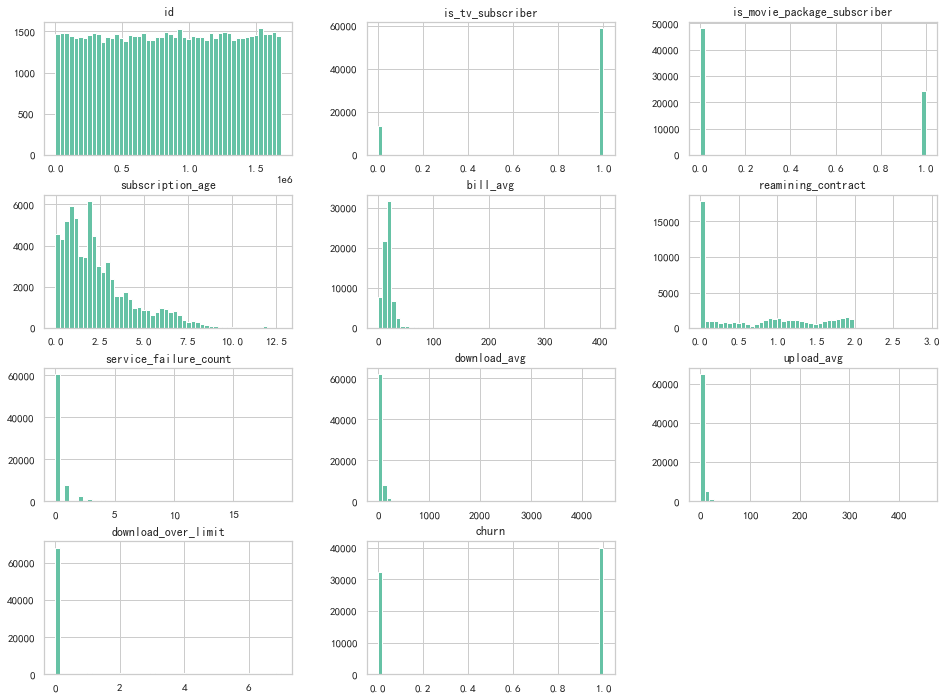

In [67]:
data.hist(bins = 50,figsize = (16,12))
plt.show()

#### 发现2

1. 着重需要<span class="girk">bill_avg</span>、<span class="girk">service_failure_count</span>、<span class="girk">download_avg</span>、<span class="girk">upload_avg</span>注意，<span class="pirk">他们在特征进行标准化之前，需先进行log化处理</span>。
2. 目标变量<span class="girk">churn不存在极度有偏的</span>情况，对我们建模来说，是相对不错的消息。

## 相关性

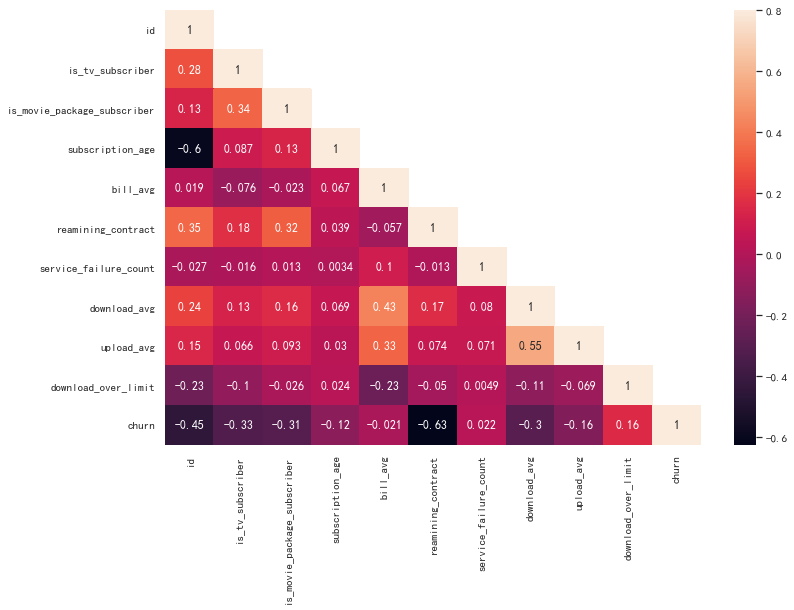

In [68]:
plt.figure(figsize = (12,8))
mask = np.array(data.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(data = data.corr(),mask=mask,vmax=0.8,annot=True)
plt.show()

### 结论1

* 目标变量churn和自变量的相关性:
    - <span class="girk">remaining_contract</span>与churn呈现出<span class="girk">中等强度的</span><span class="girk">负相关性</span>，从业务上来说客户合同所剩年限越长，客户流失的可能性就越低。
    - <span class="girk">is_tv_subscriber</span>、<span class="girk">is_movie_package_subscriber</span>、<span class="girk">download_avg</span>和churn呈现<span class="girk">弱负相关性</span>。从业务上来说，有订阅的客户比没有订阅的客户流失的可能性降低；下载量大的客户比下载量小的客户流失的可能性降低。
* 自变量之间的相关性:
    - <span class="girk">is_tv_subscriber</span>和<span class="girk">is_movie_package_subscriber</span>之间存在<span class="girk">弱正相关性</span>。从业务上来说意味订阅A的人有较大的可能订阅B，反之亦然。
    - <span class="girk">is_movie_package_subscriber</span>和<span class="girk">remaining_contract</span>之间存在<span class="girk">弱正相关性</span>。从业务上来说，可能是剩余合同时限更长的人更可能订阅电影套餐，也可能是订阅电影套餐后完成了签约行为。
    - <span class="girk">bill_avg和download_avg</span><span class="girk">以及upload_avg存在弱正相关性</span>。从业务上来说的合理推测是，上传内容或下载内容很可能都是需要付费的。
    - <span class="girk">download_avg</span>和<span class="girk">upload_avg</span>呈现<span class="girk">中等程度的正相关</span>。从业务上来说，可能是下载量更高的客户更可能拥有较高的上传量，也可能是上传量更高的客户更可能拥有较高的下载量。
    - 以上内容，考虑其相关性系数不大，<span class="pirk">存在多重共线性的可能性不大，在建模时均可保留</span>。

# 数据清洗及预处理

## 缺失值处理

先处理download_avg和upload_avg，由于从数据分布图上获取到的这两个特征的分布极度不均匀，并且空值行数占总比重较小，故不采用中位数填充的方法，直接删除空值行。

In [69]:
data.dropna(subset = ['download_avg','upload_avg'],axis = 0,how = 'any',inplace = True)
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71893 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71893 non-null  int64  
 1   is_tv_subscriber             71893 non-null  int64  
 2   is_movie_package_subscriber  71893 non-null  int64  
 3   subscription_age             71893 non-null  float64
 4   bill_avg                     71893 non-null  int64  
 5   reamining_contract           50375 non-null  float64
 6   service_failure_count        71893 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          71893 non-null  int64  
 10  churn                        71893 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.6 MB


处理reamining_contract，用0.00替代空值后，为避免与已经签订合同后所剩年限为0.00的值相同，故增加一列is_contract，reamining_contract为空值对应的值为0，反之为1。

In [70]:
# 获取reamining_contract非空值所在行的index
reamining_contract_nan_index = data.dropna(subset = 'reamining_contract',axis = 0,how = 'any').index
# 创建对应的is_contract特征（0/1）
is_contract = np.ones((len(data),1))
for index,values in enumerate(is_contract):
    if index not in reamining_contract_nan_index:
        is_contract[index] = 0
data['is_contract'] = is_contract
# 将reamining_contract空值替换为0.00
data.fillna(0.00,inplace = True)
data.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,is_contract
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0,1.0
1,18,0,0,8.22,0,0.00,0,0.0,0.0,0,1,0.0
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1,1.0
3,27,0,0,6.87,21,0.00,1,0.0,0.0,0,1,0.0
4,34,0,0,6.39,0,0.00,0,0.0,0.0,0,1,0.0


## 根据数据类型划分数据集

In [73]:
# 数值型特征对应自变量数据集
c_num = list(data.columns)[3:-2]
data_num = data[c_num]
# 类别型特征对应自变量数据集
c_object = ['is_tv_subscriber','is_movie_package_subscriber','is_contract']
data_object = data[c_object]

上一单元格侧操作隐含了删除id列。

In [82]:
# 因变量数据集
data_target = data[['churn']]

## 类别型特征独热编码处理

考虑到自变量中的三个类别特征均为二分类的情况，先不进行独热编码拆分特征，依据模型性能选择是否增加特征。

## 合并各类型数据生成新的数据集

由于目前4.3未进行特征独热编码处理，故直接使用之前的数据集data。

## 数据log化

### log化前后数据分布可视化对比

In [86]:
def hist_log(df,col_name,bins = 50,figsize = (12,6),increment = 0.01):
    '''
    原始分布可视化和数据log化后的可视化对比图
    Args:
        df:pd.DataFrame
        col_name:特征名
        increment:为防止0值不能log化，故所有值增加一个常量
    Returns:
        对比图
    '''
    plt.figure(figsize=figsize)
    
    plt.subplot(121)
    plt.hist(x = df[col_name],bins = bins)
    plt.title(col_name+'原始分布')
    
    plt.subplot(122)
    plt.hist(x = np.log(df[col_name]+increment),bins = bins)
    plt.title(col_name+'log化后分布')
    plt.show()

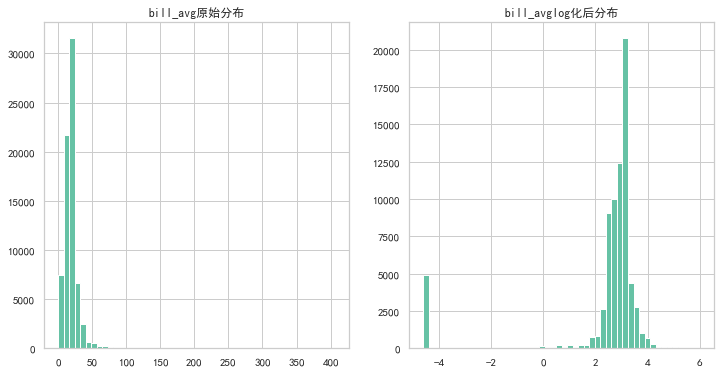

In [87]:
hist_log(data,'bill_avg')

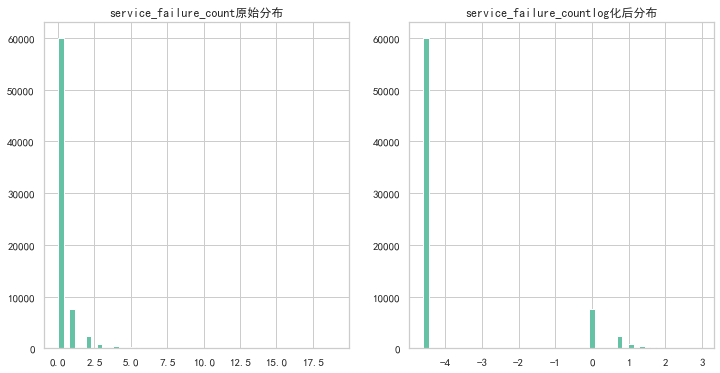

In [88]:
hist_log(data,'service_failure_count')

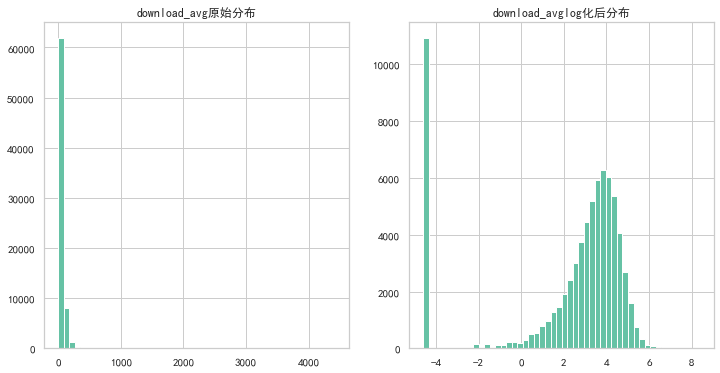

In [89]:
hist_log(data,'download_avg')

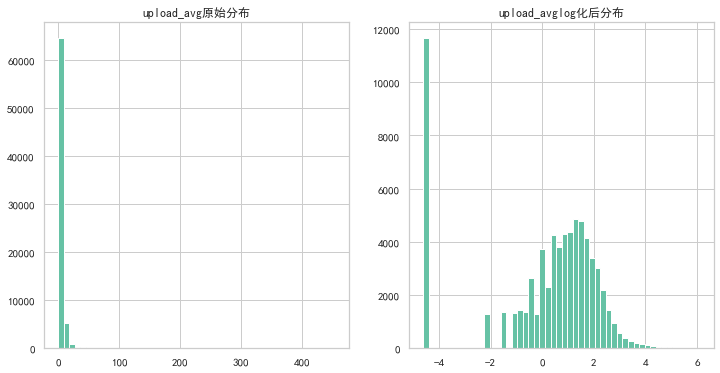

In [90]:
hist_log(data,'upload_avg')

### 数据log化处理

In [91]:
# 用log化后的值代替原始值
data['bill_avg'] = np.log(data.bill_avg+0.01)
data['service_failure_count'] = np.log(data.service_failure_count+0.01)
data['download_avg'] = np.log(data.download_avg+0.01)
data['upload_avg'] = np.log(data.upload_avg+0.01)

## 拆分训练集和测试集

In [92]:
from sklearn.model_selection import train_test_split
# 自变量特征列表
c_independent_variable = list(data.columns)[1:10]+['is_contract']
# 因变量特征列表
c_dependent_variable = ['churn']

# 切分训练集和测试集
X,X_test,y,y_test = train_test_split(data[c_independent_variable],
                                    data[c_dependent_variable],
                                    test_size = 0.3,
                                    random_state = 42)
# 重置训练集和测试集的索引index
X.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y = y.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [97]:
X.shape

(50325, 10)

## 训练集数值型特征标准化

In [96]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X[c_num])
X_c_num = pd.DataFrame(ss.transform(X[c_num]),columns = c_num)
X_tr = pd.concat([X_c_num,X[c_object]],axis = 1)
X_tr

,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,is_tv_subscriber,is_movie_package_subscriber,is_contract
0,1.658963,-0.046954,-0.750542,2.051446,-2.195039,-2.005027,-0.207563,1,0,1.0
1,0.063254,0.161275,1.230296,-0.442440,1.032308,1.185146,-0.207563,1,1,1.0
2,-0.751785,0.087777,0.810118,-0.442440,0.304134,0.070279,-0.207563,1,0,1.0
3,-1.159304,-0.101050,-0.735536,-0.442440,-2.195039,-2.005027,-0.207563,1,0,1.0
4,-0.241158,0.334116,-0.750542,2.423322,0.613268,0.784948,-0.207563,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...
50320,-0.722325,0.443842,-0.750542,2.423322,0.527404,0.419206,-0.207563,0,0,1.0
50321,-0.570119,0.046670,-0.750542,-0.442440,-2.195039,-2.005027,-0.207563,0,0,1.0
50322,-0.437553,0.334116,-0.210314,-0.442440,0.595329,0.882743,-0.207563,1,0,1.0
50323,0.524782,-3.597902,-0.750542,-0.442440,-2.195039,-2.005027,-0.207563,0,0,1.0


# 训练模型

## 逻辑回归

### 创建估计器

In [107]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_tr,y)

LogisticRegression()

In [110]:
# 训练集R²结果
lr.score(X_tr,y)

0.8836959761549925

### 交叉k折验证模型评估

In [111]:
from sklearn.model_selection import cross_val_predict
cv_predict = cross_val_predict(lr,X_tr,y,cv = 10)

In [112]:
from sklearn.metrics import accuracy_score,classification_report,f1_score,precision_score,recall_score,confusion_matrix
print('Accuracy:{}'.format(accuracy_score(y,cv_predict)))
print('Precision:{}'.format(precision_score(y,cv_predict)))
print('Recall:{}'.format(recall_score(y,cv_predict)))
print('F1_score:{}'.format(f1_score(y,cv_predict)))

print(classification_report(y,cv_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.8836363636363637
Precision:0.8742149040909862
Recall:0.9229059890326512
F1_score:0.8979008299044565
              precision    recall  f1-score   support

         未流失       0.90      0.83      0.86     22424
          流失       0.87      0.92      0.90     27901

    accuracy                           0.88     50325
   macro avg       0.89      0.88      0.88     50325
weighted avg       0.88      0.88      0.88     50325



### ROC曲线、AUC评估

In [114]:
from sklearn.metrics import roc_auc_score,roc_curve
cv_predict_prob = cross_val_predict(lr,X_tr,y.values.ravel(),cv = 10,method='predict_proba') # 返回数据集中每个样例分类为每个类的概率
fpr,tpr,thr = roc_curve(y.values.ravel(),cv_predict_prob[:,1]) #返回值fpr:所有反例中假阳的占比array，fpr越小越好；返回值tpr:所有正例中真阳的占比array，tpr越大越好
# 返回值thr:阈值array
auc = roc_auc_score(y.values.ravel(),cv_predict_prob[:,1])
print('AUC评估值:{}'.format(auc))

AUC评估值:0.9439088684223612


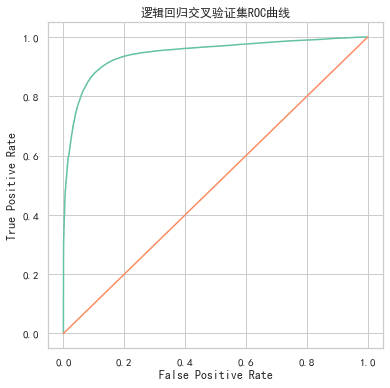

In [116]:
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'逻辑回归交叉验证集ROC曲线')
plt.show()

## 支持向量机（高斯核函数）

### 创建估计器

In [130]:
from sklearn import svm
svm_rbf = svm.SVC(kernel = 'rbf',probability=True)
svm_rbf.fit(X_tr,y)

SVC(probability=True)

In [131]:
svm_rbf.score(X_tr,y)

0.9153303527074019

### 交叉k折验证模型评估

In [132]:
from sklearn.model_selection import cross_val_predict
cv_predict = cross_val_predict(svm_rbf,X_tr,y,cv = 5)

In [133]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
print('Accuracy:{}'.format(accuracy_score(y,cv_predict)))
print('Precision:{}'.format(precision_score(y,cv_predict)))
print('Recall:{}'.format(recall_score(y,cv_predict)))
print('F1_score:{}'.format(f1_score(y,cv_predict)))

print(classification_report(y,cv_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.9137208147044212
Precision:0.9108506853615151
Recall:0.9359879574208809
F1_score:0.9232482500176765
              precision    recall  f1-score   support

         未流失       0.92      0.89      0.90     22424
          流失       0.91      0.94      0.92     27901

    accuracy                           0.91     50325
   macro avg       0.91      0.91      0.91     50325
weighted avg       0.91      0.91      0.91     50325



### ROC曲线、AUC评估

In [136]:
from sklearn.metrics import roc_auc_score,roc_curve
cv_predict_prob = cross_val_predict(svm_rbf,X_tr,y.values.ravel(),cv = 10,method='predict_proba',n_jobs = -1)

In [139]:
fpr1,tpr1,thr1 = roc_curve(y.values.ravel(),cv_predict_prob[:,1])
auc1 = roc_auc_score(y.values.ravel(),cv_predict_prob[:,1])
print('AUC评估值:{}'.format(auc))

AUC评估值:0.9559650109914772


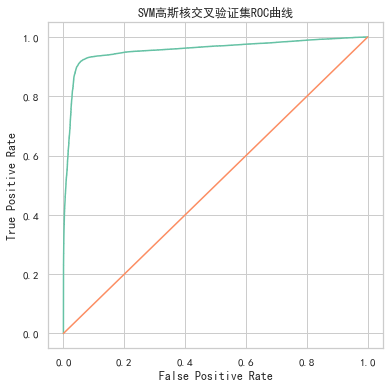

In [140]:
plt.figure(figsize = (6,6))
plt.plot(fpr1,tpr1)
plt.plot(fpr1,fpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'SVM高斯核交叉验证集ROC曲线')
plt.show()

## 神经网络

### 创建估计器

In [141]:
from sklearn.neural_network import MLPClassifier
nw = MLPClassifier(hidden_layer_sizes=(5,5))
nw.fit(X_tr,y)

MLPClassifier(hidden_layer_sizes=(5, 5))

In [142]:
nw.score(X_tr,y)

0.9337704918032786

### 交叉k折验证模型评估

In [143]:
from sklearn.model_selection import cross_val_predict
cv_predict = cross_val_predict(nw,X_tr,y,cv = 10)

In [144]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
print('Accuracy:{}'.format(accuracy_score(y,cv_predict)))
print('Precision:{}'.format(precision_score(y,cv_predict)))
print('Recall:{}'.format(recall_score(y,cv_predict)))
print('F1_score:{}'.format(f1_score(y,cv_predict)))

print(classification_report(y,cv_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.9334923000496771
Precision:0.9470215554908243
Recall:0.9321888104369019
F1_score:0.9395466449923237
              precision    recall  f1-score   support

         未流失       0.92      0.94      0.93     22424
          流失       0.95      0.93      0.94     27901

    accuracy                           0.93     50325
   macro avg       0.93      0.93      0.93     50325
weighted avg       0.93      0.93      0.93     50325



### ROC曲线、AUC评估

In [146]:
from sklearn.metrics import roc_auc_score,roc_curve
cv_predict_prob = cross_val_predict(nw,X_tr,y.values.ravel(),cv = 10,method='predict_proba')

In [147]:
fpr2,tpr2,thr2 = roc_curve(y.values.ravel(),cv_predict_prob[:,1])
auc = roc_auc_score(y.values.ravel(),cv_predict_prob[:,1])
print('AUC评估值:{}'.format(auc))

AUC评估值:0.9618824960438392


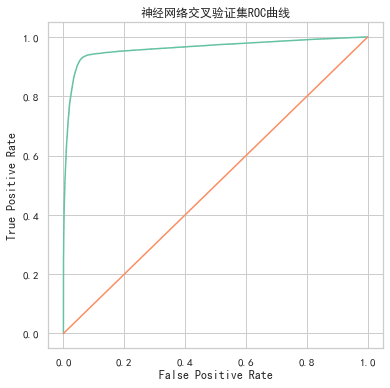

In [148]:
plt.figure(figsize=(6,6))
plt.plot(fpr2,tpr2)
plt.plot(fpr2,fpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'神经网络交叉验证集ROC曲线')
plt.show()

## 随机森林

### 创建估计器

In [149]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,n_jobs = -1)
rfc.fit(X_tr,y)

RandomForestClassifier(n_jobs=-1)

In [150]:
rfc.score(X_tr,y)

0.9999602583209141

### 交叉k折验证模型评估

In [151]:
from sklearn.model_selection import cross_val_predict
cv_predict = cross_val_predict(rfc,X_tr,y,cv = 10,n_jobs = -1)

In [152]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
print('Accuracy:{}'.format(accuracy_score(y,cv_predict)))
print('Precision:{}'.format(precision_score(y,cv_predict)))
print('Recall:{}'.format(recall_score(y,cv_predict)))
print('F1_score:{}'.format(f1_score(y,cv_predict)))

print(classification_report(y,cv_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.9411028315946349
Precision:0.9556700654168037
Recall:0.9372423927457797
F1_score:0.9463665315576143
              precision    recall  f1-score   support

         未流失       0.92      0.95      0.93     22424
          流失       0.96      0.94      0.95     27901

    accuracy                           0.94     50325
   macro avg       0.94      0.94      0.94     50325
weighted avg       0.94      0.94      0.94     50325



### ROC曲线、AUC评估

In [155]:
from sklearn.model_selection import cross_val_predict
cv_predict_prob = cross_val_predict(rfc,X_tr,y.values.ravel(),cv = 10,method = 'predict_proba')

In [156]:
from sklearn.metrics import roc_auc_score,roc_curve
fpr3,tpr3,thr3 = roc_curve(y.values.ravel(),cv_predict_prob[:,1])
auc = roc_auc_score(y.values.ravel(),cv_predict_prob[:,1])
print('AUC评估值:{}'.format(auc))

AUC评估值:0.9786178378925856


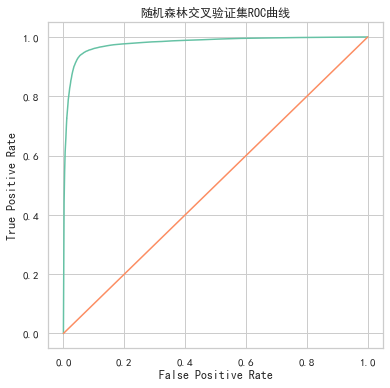

In [157]:
plt.figure(figsize=(6,6))
plt.plot(fpr3,tpr3)
plt.plot(fpr3,fpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'随机森林交叉验证集ROC曲线')
plt.show()

## 小结

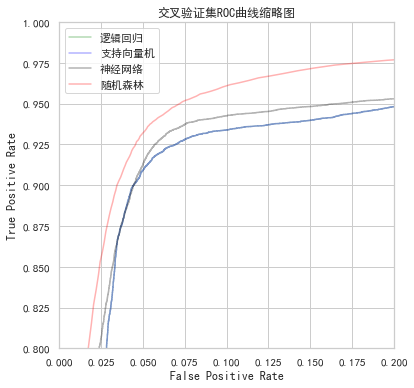

In [170]:
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,color = 'green',alpha = 0.3,label = '逻辑回归')
plt.plot(fpr1,tpr1,color = 'blue',alpha = 0.3,label = '支持向量机')
plt.plot(fpr2,tpr2,color = 'black',alpha = 0.3,label = '神经网络')
plt.plot(fpr3,tpr3,color = 'red',alpha = 0.3,label = '随机森林')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'交叉验证集ROC曲线缩略图')
plt.ylim([0.8,1])
plt.xlim([0.0,0.2])
plt.legend()
plt.show()

* **ROC曲线**

上图展现出了四种算法在ROC曲线表现方面的差异，其中表现最佳的是<span class="girk">随机森林</span>，其次为<span class="girk">神经网络</span>，支持向量机和逻辑回归表现相当。

* **评估指标**

| 算法名 | f1_score | AUC |
| --- | --- | --- |
| 逻辑回归 | 0.8979 | 0.9439 |
| 支持向量机 | 0.9232 | 0.9559 |
| 神经网络 | 0.9395 | 0.9619 |
| 随机森林 | 0.9464 | 0.9786 |

在评估指标这方面，很明显<span class="girk">随机森林</span>的表现也是表现最佳的，<span class="girk">神经网络</span>其次。于是在之后的模型调优方面，着重调整这两种算法的参数，以求在训练集上更好的表现。

# 模型调优

## 神经网络的模型调优

### 确定层数

In [177]:
from sklearn.model_selection import GridSearchCV
param_grid = {'hidden_layer_sizes':[(100,),(100,100),(100,100,100)]}
grid_search = GridSearchCV(nw,param_grid = param_grid,scoring='f1',cv = 5)
grid_search.fit(X_tr,y)

GridSearchCV(cv=5, estimator=MLPClassifier(hidden_layer_sizes=(5, 5)),
             param_grid={'hidden_layer_sizes': [(100,), (100, 100),
                                                (100, 100, 100)]},
             scoring='f1')

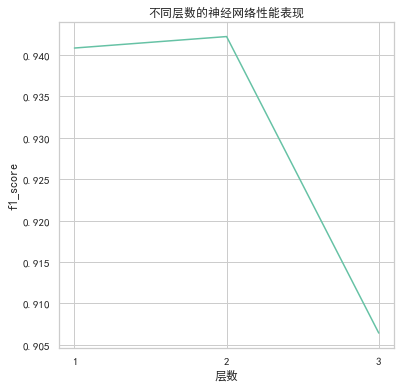

In [189]:
plt.figure(figsize = (6,6))
plt.plot([1,2,3],list(grid_search.cv_results_['mean_test_score']))
plt.xticks([1,2,3])
plt.ylabel('f1_score')
plt.xlabel(u'层数')
plt.title(u'不同层数的神经网络性能表现')
plt.show()

可以看到当层数为2的时候，模型f1_score的评分是最佳的。

### 确定每层节点数

In [190]:
from sklearn.model_selection import GridSearchCV
param_grid = {'hidden_layer_sizes':[(5,5),(10,10),(25,25),(50,50),(75,75),(100,100)]}
grid_search = GridSearchCV(nw,param_grid = param_grid,cv = 10,scoring='f1')
grid_search.fit(X_tr,y)

GridSearchCV(cv=10, estimator=MLPClassifier(hidden_layer_sizes=(5, 5)),
             param_grid={'hidden_layer_sizes': [(5, 5), (10, 10), (25, 25),
                                                (50, 50), (75, 75),
                                                (100, 100)]},
             scoring='f1')

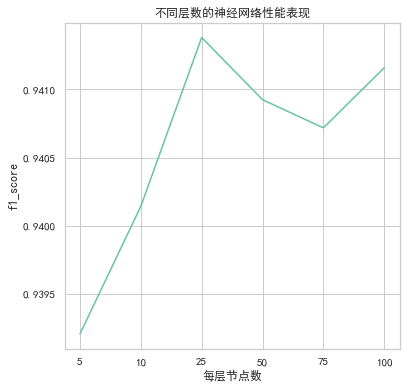

In [195]:
plt.figure(figsize = (6,6))
plt.plot([1,2,3,4,5,6],list(grid_search.cv_results_['mean_test_score']))
plt.xticks([1,2,3,4,5,6],['5','10','25','50','75','100'])
plt.ylabel('f1_score')
plt.xlabel(u'每层节点数')
plt.title(u'不同层数的神经网络性能表现')
plt.show()

可以看到当每层节点数为25的时候，模型表现最佳。综上最终选定的参数为<span class="girk">hidden_layer_sizes = (25,25)</span>.

### 获取最佳模型

In [196]:
nw_best_estimator = grid_search.best_estimator_

## 随机森林的模型调优

### 确定包含决策树的数量

In [198]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[50,100,150,200]}
grid_search = GridSearchCV(rfc,param_grid = param_grid,cv = 5,scoring = 'f1')
grid_search.fit(X_tr,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'n_estimators': [50, 100, 150, 200]}, scoring='f1')

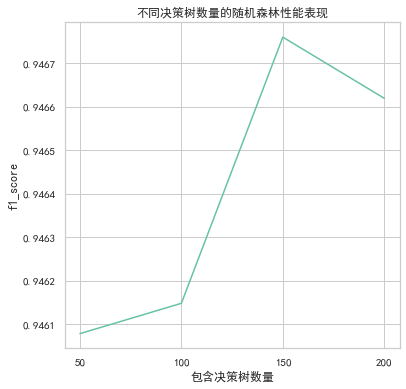

In [200]:
plt.figure(figsize = (6,6))
plt.plot([1,2,3,4],list(grid_search.cv_results_['mean_test_score']))
plt.xticks([1,2,3,4],['50','100','150','200'])
plt.ylabel('f1_score')
plt.xlabel(u'包含决策树数量')
plt.title(u'不同决策树数量的随机森林性能表现')
plt.show()

可以看到就此训练集来说，随机森林模型包含决策树数量为150的时候，性能最佳(f1_score:0.94675999)。

### 确定考虑特征的数量（max_features）

In [209]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_features':[2,3,5,None],
             'n_estimators':[150]}
grid_search = GridSearchCV(rfc,param_grid = param_grid,cv = 5,scoring = 'f1')
grid_search.fit(X_tr,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_features': [2, 3, 5, None],
                         'n_estimators': [150]},
             scoring='f1')

In [210]:
grid_search.cv_results_

{'mean_fit_time': array([2.72638216, 3.08801341, 4.26002259, 7.3654273 ]),
 'std_fit_time': array([0.11051952, 0.02406807, 0.02694371, 0.06505477]),
 'mean_score_time': array([0.18196697, 0.17362313, 0.16216564, 0.1626657 ]),
 'std_score_time': array([0.02303764, 0.00973187, 0.0092402 , 0.0087471 ]),
 'param_max_features': masked_array(data=[2, 3, 5, None],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[150, 150, 150, 150],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 2, 'n_estimators': 150},
  {'max_features': 3, 'n_estimators': 150},
  {'max_features': 5, 'n_estimators': 150},
  {'max_features': None, 'n_estimators': 150}],
 'split0_test_score': array([0.94391171, 0.94500724, 0.9466462 , 0.94636429]),
 'split1_test_score': array([0.9465497 , 0.94727322, 0.94967928, 0.94931125]),
 'split2_test_score': array

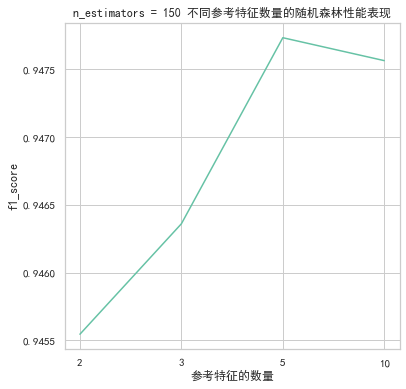

In [211]:
plt.figure(figsize = (6,6))
plt.plot([1,2,3,4],list(grid_search.cv_results_['mean_test_score']))
plt.xticks([1,2,3,4],['2','3','5','10'])
plt.ylabel('f1_score')
plt.xlabel(u'参考特征的数量')
plt.title(u'n_estimators = 150 不同参考特征数量的随机森林性能表现')
plt.show()

可以看到就此训练集来说，当n_estimators = 150时，参考特征的数量为5的情况下性能最佳(f1_score = 0.94773367)。综上最终选定的模型参数为{n_estimatros = 150,max_features = 5}。

### 获取最佳模型

In [212]:
rfc_best_estimator = grid_search.best_estimator_

# 测试集表现

## 测试集自变量数据处理

In [214]:
X_test_c_num = pd.DataFrame(ss.transform(X_test[c_num]),columns = c_num)
X_test_tr = pd.concat([X_test_c_num,X_test[c_object]],axis = 1)
X_test_tr.head()

,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,is_tv_subscriber,is_movie_package_subscriber,is_contract
0,-0.187149,0.254927,2.025632,-0.442440,0.811971,1.136247,-0.207563,1,1,1.0
1,0.942122,0.282701,2.100664,-0.442440,0.326695,0.866011,-0.207563,0,0,1.0
2,-1.105295,0.125839,-0.750542,-0.442440,-0.178824,-0.519021,-0.207563,0,0,1.0
3,-1.085656,0.046670,-0.750542,-0.442440,0.412384,0.676391,-0.207563,1,0,1.0
4,0.809555,0.254927,1.995619,2.423322,0.853708,0.718356,-0.207563,1,1,1.0


## 神经网络

### 模型评估

In [215]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,classification_report,confusion_matrix
y_predict = nw_best_estimator.predict(X_test_tr)
print('Accuracy:{}'.format(accuracy_score(y_test,y_predict)))
print('Precision:{}'.format(precision_score(y_test,y_predict)))
print('Recall:{}'.format(recall_score(y_test,y_predict)))
print('f1_score:{}'.format(f1_score(y_test,y_predict)))

print(classification_report(y_test,y_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.9371754451038575
Precision:0.9500500333555704
Recall:0.9377726561856943
f1_score:0.9438714220620521
              precision    recall  f1-score   support

         未流失       0.92      0.94      0.93      9419
          流失       0.95      0.94      0.94     12149

    accuracy                           0.94     21568
   macro avg       0.94      0.94      0.94     21568
weighted avg       0.94      0.94      0.94     21568



### ROC曲线、AUC评估

In [216]:
from sklearn.metrics import roc_auc_score,roc_curve
y_predict_proba = nw_best_estimator.predict_proba(X_test_tr)
fpr1,tpr1,thr1 = roc_curve(y_test.values.ravel(),y_predict_proba[:,1])
auc = roc_auc_score(y_test.values.ravel(),y_predict_proba[:,1])
print('测试集AUC评估值:{}'.format(auc))

测试集AUC评估值:0.9711210637573867


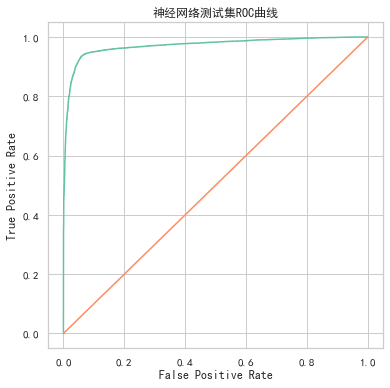

In [217]:
plt.figure(figsize=(6,6))
plt.plot(fpr1,tpr1)
plt.plot(fpr1,fpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'神经网络测试集ROC曲线')
plt.show()

## 随机森林

### 模型评估

In [218]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,classification_report,confusion_matrix
y_predict = rfc_best_estimator.predict(X_test_tr)
print('Accuracy:{}'.format(accuracy_score(y_test,y_predict)))
print('Precision:{}'.format(precision_score(y_test,y_predict)))
print('Recall:{}'.format(recall_score(y_test,y_predict)))
print('f1_score:{}'.format(f1_score(y_test,y_predict)))

print(classification_report(y_test,y_predict,labels = [0,1],target_names = ['未流失','流失']))

Accuracy:0.9432956231454006
Precision:0.95525
Recall:0.9435344472796114
f1_score:0.9493560809971427
              precision    recall  f1-score   support

         未流失       0.93      0.94      0.94      9419
          流失       0.96      0.94      0.95     12149

    accuracy                           0.94     21568
   macro avg       0.94      0.94      0.94     21568
weighted avg       0.94      0.94      0.94     21568



### ROC曲线、AUC评估

In [220]:
from sklearn.metrics import roc_auc_score,roc_curve
y_predict_proba = rfc_best_estimator.predict_proba(X_test_tr)
fpr2,tpr2,thr2 = roc_curve(y_test.values.ravel(),y_predict_proba[:,1])
auc = roc_auc_score(y_test.values.ravel(),y_predict_proba[:,1])
print('测试集AUC评估值:{}'.format(auc))

测试集AUC评估值:0.9801920811424618


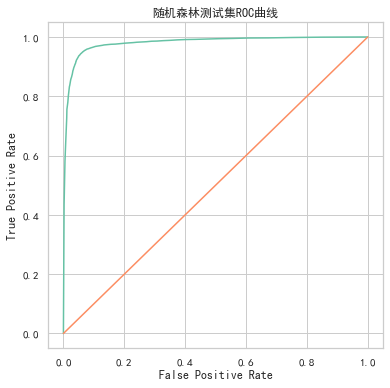

In [221]:
plt.figure(figsize=(6,6))
plt.plot(fpr2,tpr2)
plt.plot(fpr2,fpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(u'随机森林测试集ROC曲线')
plt.show()

## 小结

从神经网络和随机森林在测试集上的表现来看，随机森林的表现更优。<span class="girk">于是未来在做有关于客户流失可能性预测的时候，随机森林算法更适用</span>。

| 算法名 | f1_score | AUC |
| --- | --- | --- |
| 神经网络 | 0.9439 | 0.9711 |
| 随机森林 | 0.9494 | 0.9802 |

# 业务建议

In [223]:
rfr_importance_dict = {'特征':X_tr.columns,
                     '系数绝对值':abs(rfc_best_estimator.feature_importances_),
                      '系数值':rfc_best_estimator.feature_importances_}
rfr_importance_df = pd.DataFrame(rfr_importance_dict)
rfr_importance_df.sort_values('系数绝对值',ascending = False,inplace=True)
rfr_importance_df.reset_index(drop = True,inplace = True)
rfr_importance_df

,特征,系数绝对值,系数值
0,reamining_contract,0.646283,0.646283
1,download_avg,0.129147,0.129147
2,upload_avg,0.072023,0.072023
3,subscription_age,0.061386,0.061386
4,bill_avg,0.048590,0.048590
5,is_movie_package_subscriber,0.014753,0.014753
6,is_tv_subscriber,0.013844,0.013844
7,is_contract,0.006121,0.006121
8,service_failure_count,0.005866,0.005866
9,download_over_limit,0.001987,0.001987


上述表格展示了各特征在随机森林模型中的系数比重，可以看出'<span class="girk">客户合同所剩年限</span>'这一特征对判断客户流失可能性的结果起到至关重要的作用，结合在探索数据环节的相关性模块的分析结果，可得到如下推论：<span class="girk">客户合同所剩年限越长，流失的可能性越低</span>；影响权重其次的是'<span class="girk">客户过去3个月平均下载量（GB）</span>'，同样是结合之前相关性的分析结果，可获得推论：<span class="girk">下载量越低，流失的可能性越高</span>。<span class="pirk">但由于这一特征的影响权重远低于'客户合同所剩年限'，所得推论的影响力有限</span>。